В данном проекте будет проведен анализ статистики популярного сервиса аренды самокатов GoFast. Нам были переданы данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**1) без подписки**
- абонентская плата отсутствует
- стоимость одной минуты поездки — 8 рублей
- стоимость старта (начала поездки) — 50 рублей

**2) с подпиской Ultra**
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

Изначально в нашем рспоряжении имеются три датасета: с информацией о тарифных планах, информацией о поездках и информацией о пользователях. 

Начнем с импорта необходимых библиотек и открытия имеющихся датасетов. Затем изучим их и проведем предобработку данных. Затем приступим непосредственно к исследовательскому анализу данных. В нем мы выявим некоторые закономерности и обозначим явления, справедливые для этого конкретного бизнеса. Затем мы сможем объеденить данные. Таким образом, получив единый, максимально полный датасет мы сможем перейти к подсчёту выручки и работе над бизнес гипотезами.

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

**Начнем с изучения информации о пользователях (users):**

In [3]:
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Построю гистограмму, чтобы оценить возрастной состав пользователей

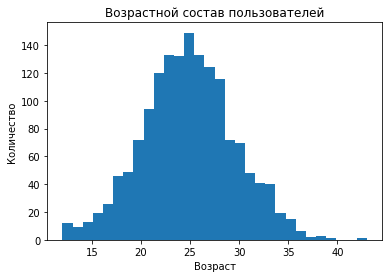

In [4]:
plt.hist(users['age'], bins = 30);
plt.title('Возрастной состав пользователей');
plt.xlabel('Возраст');
plt.ylabel('Количество');

Из данной гистограммы можно сделать вывод, что распределение пользователей по возрасту близко к нормальному.

Теперь оценим распределение пользователей по городам

In [5]:
users['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

Выяснилось, что всего сервис работает в 8 городах, причем ни один из них не имеет значительного перевеста в количестве пользователей относительно других.

Напоследок оценим как распределяются пользователи по типу подписки:

In [6]:
users['subscription_type'].value_counts()

free     846
ultra    719
Name: subscription_type, dtype: int64

**Теперь изучу данные о поездках (rides):**

In [7]:
print(rides.info())
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Из сводки по датафрейму следует, что столбец date не приведен к типу "дата". В дальнейшм я это исправлю.

Выясню кто чаще всех пользовался приложением, а также кто пользовался им дольше всего:

In [8]:
print('Максимальное суммарно проеханное расстояние и время в поездке')
rides.pivot_table(index = 'user_id', aggfunc = 'sum').max()

Максимальное суммарно проеханное расстояние и время в поездке


distance    79325.846482
duration      446.233013
dtype: float64

Остался один неизученный датафрейм. Это информация о подписках. Перейдем к нему:

In [9]:
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Этот датафрейм совсем небольшой и да1т исчерпывающую информацию о тарифах компании.

На этом загрузка и первичное изучение данных завершено. Теперь можно перейти к их предобработки для дальнейшей работы с ними.

#### Шаг 2. Предобработка данных

Как было отмеченно раньше, необходимо привести столбец **date** к соответствующему формату в датафрейме **rides**. Сделаю это:

In [10]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')

Добавлю в текущем датафрейме столбец **'month'** на основе столбца **date** :

(И начала оценю значения **month**. Они должны лежать в диапазоне [1, 12])

In [11]:
rides['month'] = rides['date'].dt.month

In [12]:
check = rides['month'].unique().tolist()
check.sort()
check

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Аномалий в индексах месяца не обнаружено.

Проверим также какие года мы исследуем. Это поможет избежать смешения данных по месяцам разных лет:

In [13]:
years = rides['date'].dt.year
years.unique()

array([2021])

Год всего один! Значит каждый исследуемый месяц соответствует одному конкретному месяцу в 2021 году

Теперь оценим количество пропущенных данных в каждом из имеющихся датафреймов:

In [14]:
dfs = [users, rides, subs]
for entry in dfs:
    print(entry.isna().sum())
    print('='*100)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Пропущенные значения отсутствуют во всех трех датафреймах. 

Последняя часть в блоке по предобработке данных - это дубликаты. Избавлюсь от них.

In [15]:
users.duplicated().sum()

31

В датафрейме **users** 31 дубликат. От них-то и избавлюсь.

In [16]:
users.drop_duplicates(inplace=True)

Проверим, что дубликаты убраны:

In [17]:
users.duplicated().sum()

0

Мы **НЕ** станем проверять на дубликаты датафрейм **subs**, посколько это чисто информационная таблица. Однако, датафрейм **rides** в очистке от дубликатов все же нуждается

In [18]:
rides.duplicated().sum()

0

Их там нет. Следовательно, можно сделать подвывод:

- Пропущенных значений в датафреймах нет
- Дубликаты есть только в датафрейме **rides**. Они удалены.

На этом предобработку данных можно считать завершенной.

#### Шаг 3. Исследовательский анализ данных

Прежде всего оценю частоту встречаемости городов. Построю столбчатую диграмму

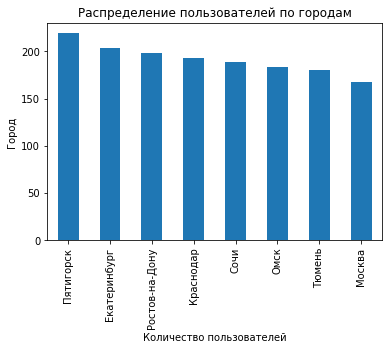

In [19]:
usg = users['city'].value_counts().plot(kind = 'bar', title = 'Распределение пользователей по городам');
usg.set_xlabel("Количество пользователей")
usg.set_ylabel("Город");

Как видно из столбчатой диаграммы, самое большое количество пользователей в Пятигорске. Наименьшее - в Москве. Однако разница между городами по количеству пользоватеелй небольшая. Найду долю, занимаемую каждым городом:

In [20]:
print(round(users['city'].value_counts() / users['city'].value_counts().sum() * 100, 2))

Пятигорск         14.28
Екатеринбург      13.30
Ростов-на-Дону    12.91
Краснодар         12.58
Сочи              12.32
Омск              11.93
Тюмень            11.73
Москва            10.95
Name: city, dtype: float64


Теперь оценимм кого больше: пользователей с подпиской или без? И на сколько.

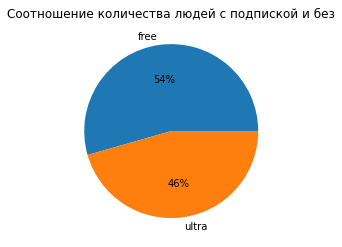

In [21]:
users['subscription_type'].value_counts().plot(kind = 'pie', autopct = '%1.0f%%', ylabel = '', title = 'Соотношение количества людей с подпиской и без');

Неудивительно, но платящих за "Ультра" тариф меньше, чем тех, кто пользуются бесплатным вариантом. Однако разница между ними всего 8% (Примерно 122 человека)

Ранее я уже оценил возраст пользователей. Приведу заранее построенную гистограмму ещё раз:

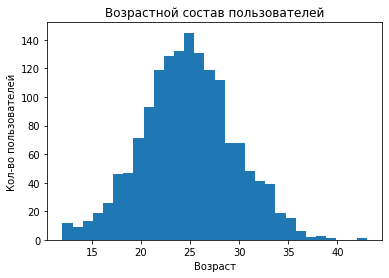

In [22]:
plt.hist(users['age'], bins = 30)
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей')
plt.title('Возрастной состав пользователей');

Распределение близко к нормальному. Значительных выбросов нет.

Выясню средний возраст, самого старшего и самого младшего из пользователей:

In [23]:
print('Максимальный возраст:', users['age'].max())
print('Минимальный возраст:', users['age'].min())
print('Средний возраст:', round(users['age'].mean(), 1))

Максимальный возраст: 43
Минимальный возраст: 12
Средний возраст: 24.9


Теперь обращусь к расстоянию, которое проезжают пользователи. Построю гистограмму:

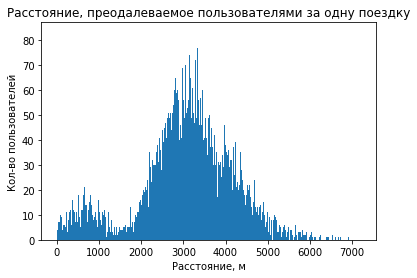

In [24]:
plt.hist(rides['distance'], bins = 1000)
plt.xlabel('Расстояние, м')
plt.ylabel('Кол-во пользователей')
plt.title('Расстояние, преодалеваемое пользователями за одну поездку');

Для оценки дальностей поездок построю график типа boxplot:

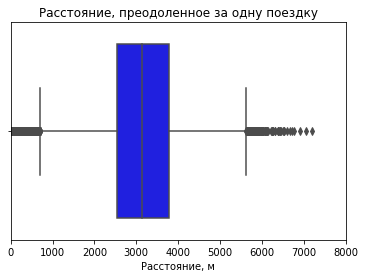

In [25]:
sns.boxplot(x=rides['distance'], color='blue')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
_ = plt.xlim(0, 8000)

Из данных, которые мы визуализировали выше следует, что в основном самокаты берут для:

- Поездок на очень короткие дистанции (~500 метров)
- Поездок на средние дистанции (~ 3.5 километра)

Два тих пика могут быть объяснены тем, что много людей оплачивает самока просто чтобы опробовать сервис. Отсюда скачок поездок на очень маленькие расстояния. Второй же пик скорее всего обусловлен большинством, которое арендует самокат для поездок на дистанции большеватые для преодаления его пешком. Именно такие пользователи представляют большинство, пользующееся сервисом.

Оценим продолжительность поездок. Для начала прострою гистограмму:

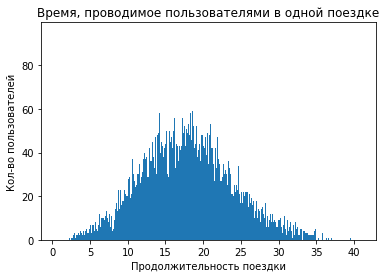

In [26]:
plt.hist(rides['duration'], bins = 1000)
plt.xlabel('Продолжительность поездки')
plt.ylabel('Кол-во пользователей')
plt.title('Время, проводимое пользователями в одной поездке');

Можно заметить, что гистограммы длительности и дальности поездок имеют "провал" между маленьким пиком в начале и основным пиком. Скорее всего это потому что длительность и дальность поездок в какой-то степени коррелируют между собой.

Узнаю среднее, максимальное и минимальное время поездок:

In [27]:
print('Максимальное время поездки:', rides['duration'].max())
print('Минимальное время поездки:', rides['duration'].min())
print('Среднее время поездки:', rides['duration'].mean())

Максимальное время поездки: 40.82396261922424
Минимальное время поездки: 0.5
Среднее время поездки: 17.80501119798444


Составлю таблицу с общим временем, поведенному в пути и преодолённому расстоянию по каждому пользователю:

In [28]:
grouped_rides = rides[['distance', 'duration']].groupby(by = rides['user_id']).sum(numeric_only = True)
grouped_rides

,distance,duration
user_id,,
1,34070.182066,204.604909
2,33964.058614,197.644279
3,36907.597866,233.193513
4,44837.189916,288.563581
5,35556.949649,174.073932
...,...,...
1530,46758.469822,292.366839
1531,67054.794222,408.192206
1532,33902.203192,212.160144


На этом исследовательский анализ данных можно завершить. Сделаем подытог:

**Частота встречаемости городов:**

- Самый встречающийся в заказах город - Пятигорск. 
- Самый редко встречающийся в заказах город- Москва. 

Возможно это связано с высокой конкуренцией в столице и низкой в сравнительно небольшом Пятигорске.

**Баланс пользователей с подпиской и без нее:**

Большинство пользователей НЕ оплачивают подписку. Их доля составляет **54%** от общей доли пользователей. 

**Возраст пользователей:**

- Самому младшему пользователю 12 лет. 
- Самому старшему пользователю 43 года. 

Однако основную массу тех, кто использует самокаты составляют взрослые люди **22-26** лет.

**Дистанция, преодалеваемая пользователями:**

Как правило пользователи берут самокат на расстояние 3-4 километра. Однако есть и заметная масса пользователей, которые проезжают ~500 метров. Скорее всего это те, кто берет самокат в аренду просто попробовать.

**Время, которое пользователи проводят в пути:**

- Самые короткие поездки - 30-секундные
- Самые длительные поездки - 40 минутные
 
В среднем в пути люди проводят около **17 минут**.

#### Шаг 4. Объединение данных

Объединим данные о пользователях в единый датафрейм:

In [29]:
full_data = users.merge(rides)
full_data = full_data.merge(subs)
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Проверим соответствие размерностей таблиц:

Сложим значения размеров таблиц

In [30]:
lst = [rides, users, subs]
for entry in lst:
    print(entry.shape)

(18068, 5)
(1534, 5)
(2, 4)


Всего у нас должно быть 18086 колонок, так как full data описывает каждую отдельную поездку.
Столбцов у нас должно быть равно сумме столбцов объединяемых датафреймов - 2, так как в датафрейме rides указан user id, а в датафрейме users указан subscription type.

Итого размер full_data должен равняться (18068, 12)

In [31]:
if full_data.shape == (18068, 12):
    print('РАЗМЕРНОСТЬ ТАБЛИЦ СОВПАДАЕТ')
else: 
    print('ОШИБКА. ОБЪЕДИНЕНИЕ НЕ ВЕРНО!')

РАЗМЕРНОСТЬ ТАБЛИЦ СОВПАДАЕТ


Объединение прошло как надо, можно двигатьяс дальше.

Отдельно создам датафрейм о пользователях без подписки:

In [32]:
free_sub = full_data.query("`subscription_type` == 'free'")
free_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Используя созданный выше датафрейм, я визуализирую информацию о дистанции поездок и времени в пути по бесплатному тарифу:

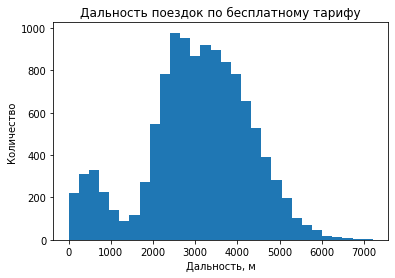

In [33]:
fsd = free_sub['distance'].plot(kind = 'hist', bins = 30, title = 'Дальность поездок по бесплатному тарифу', xlabel = 'asd');
fsd.set_xlabel("Дальность, м")
fsd.set_ylabel("Количество");

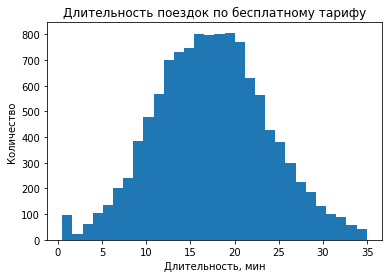

In [34]:
fst = free_sub['duration'].plot(kind = 'hist', bins = 30, title = 'Длительность поездок по бесплатному тарифу', xlabel = 'asd');
fst.set_xlabel("Длительность, мин")
fst.set_ylabel("Количество");

Как следует из визуализированной информации, пользователи с бесплатным тарифом в среднем пользуются самокатом 15-20 минут и проезжают 3-4 километра. Нашлись и такие пользователи, что проезжали более 7 километров.

Теперь обратимся к данным по платному тарифу (Ultra):

In [35]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
ultra_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


Используя созданный выше датафрейм, я визуализирую информацию о дистанции поездок и времени в пути по Ultra тарифу:

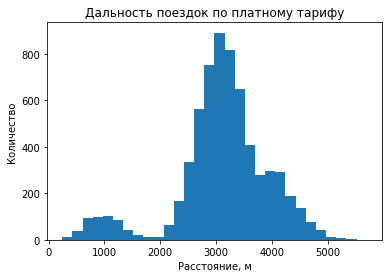

In [36]:
usd = ultra_sub['distance'].plot(kind = 'hist', bins = 30, title = 'Дальность поездок по платному тарифу', xlabel = 'asd');
usd.set_xlabel("Расстояние, м")
usd.set_ylabel("Количество");

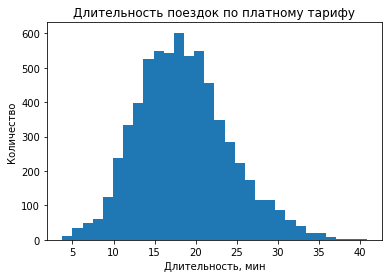

In [37]:
ust = ultra_sub['duration'].plot(kind = 'hist', bins = 30, title = 'Длительность поездок по платному тарифу', xlabel = 'asd');
ust.set_xlabel("Длительность, мин")
ust.set_ylabel("Количество");

А теперь сравним показатели разных подписок:

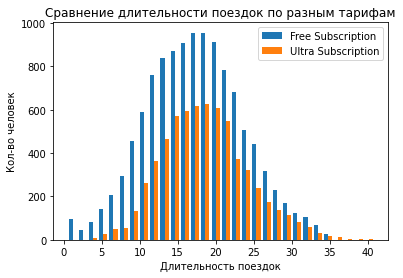

In [38]:
plt.hist([free_sub['duration'], ultra_sub['duration']], bins = 30)
plt.xlabel('Длительность поездок')
plt.ylabel('Кол-во человек')
plt.title('Сравнение длительности поездок по разным тарифам')
plt.legend(('Free Subscription', 'Ultra Subscription'), loc='upper right');

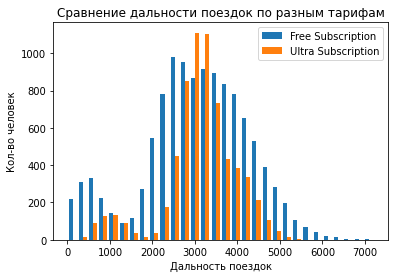

In [39]:
plt.hist([free_sub['distance'], ultra_sub['distance']], bins = 30)
plt.xlabel('Дальность поездок')
plt.ylabel('Кол-во человек')
plt.title('Сравнение дальности поездок по разным тарифам')
plt.legend(('Free Subscription', 'Ultra Subscription'), loc='upper right');

Как следует из визуализированной информации, пользователи с платным тарифом чаще всего проезжают 3 километра. Среди них также наблюдается когорта тех, кто проезжает примерно по 1 километру. При этом длительность поездок по платному почти не отличается от длительности поездок по бесплатному тарифу и составляет 15-20 минут.

**Сделаем подвывод**

Пользователи, пользующиеся бесплатным тарифом склонны к преодалению больших расстояний за одну поездку, чем подписчики тарифа Ultra. При этом и те, и те находятся в одной поездке примерно 15-20 минут, но среди пользователей бесплатного тарифа больше тех, кто предпочитает более длительные поездки (20+ минут).

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
general_data = pd.pivot_table(full_data, index=['month', 'user_id'], values = ['distance', 'duration', 'name', 'subscription_type'], 
                            aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})
general_data['duration'] = np.ceil(general_data['duration'])
general_data.rename(columns = {'name' : 'rides'}, inplace = True)
general_data.sort_values(by = ['month', 'user_id'])
general_data

distance  duration  rides subscription_type
month user_id                                                
1     1        7027.511294      42.0      2             ultra
      3        3061.777147      13.0      1             ultra
      5        3914.646990      13.0      1             ultra
      7        6478.080979      28.0      2             ultra
      12       3577.151148      33.0      1             ultra
...                    ...       ...    ...               ...
12    1525     4597.854350      34.0      1              free
      1526     3644.121544      23.0      1              free
      1528     3998.569324      11.0      1              free
      1532     6111.889853      41.0      2              free
      1534     2371.711192      16.0      1              free

[11331 rows x 4 columns]

Проверим таблицу на пропуски и дубликаты строк:

In [41]:
general_data.isna().sum()

distance             0
duration             0
rides                0
subscription_type    0
dtype: int64

In [42]:
general_data.duplicated().sum()

0

Ни пропусков, ни дубликатов в таблице нет.

Теперь к датафрейму выше добавлю столбец помесячной выручки:

In [43]:
def vyroochka(row):
    if row['subscription_type'] == 'ultra':
        return 6*row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['rides']
    else:
        return 'SUBSCRIPTION ERROR: CHECK SUBSCRIPTION DATA'

* *ipp = income per person*

In [44]:
general_data['ipp'] = general_data.apply(vyroochka, axis = 1)
general_data['ipp'] = general_data['ipp'].astype('int')

Проверим результат:

In [45]:
general_data

distance  duration  rides subscription_type  ipp
month user_id                                                     
1     1        7027.511294      42.0      2             ultra  451
      3        3061.777147      13.0      1             ultra  277
      5        3914.646990      13.0      1             ultra  277
      7        6478.080979      28.0      2             ultra  367
      12       3577.151148      33.0      1             ultra  397
...                    ...       ...    ...               ...  ...
12    1525     4597.854350      34.0      1              free  322
      1526     3644.121544      23.0      1              free  234
      1528     3998.569324      11.0      1              free  138
      1532     6111.889853      41.0      2              free  428
      1534     2371.711192      16.0      1              free  178

[11331 rows x 5 columns]

Отлично. Столбец ipp был добавлен к нашему датафрейму. В дальнейшем это сильно поможет при проверке гипотез.

#### Шаг 6. Проверка гипотез

**Гипотеза 1:**

Тратят ли пользователи с подпиской больше времени на поездки?

H0: Время, проведенное пользователями с подпиской Ультра в пути РАВНО времени, проведенном в пути пользователями с бесплатной подпиской

H1: Время, проведенное пользователями с подпиской Ультра в пути БОЛЬШЕ времени, проведенном в пути пользователями с бесплатной подпиской

In [46]:
checker = st.ttest_ind(ultra_sub['duration'], free_sub['duration'], alternative = 'greater')
alpha = 0.05
res = checker.pvalue

print('p-value:',checker.pvalue)

if res < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нулевая Гипотеза подтверждается.')

p-value: 1.2804098316645618e-34
Нулевая гипотеза отвергается.


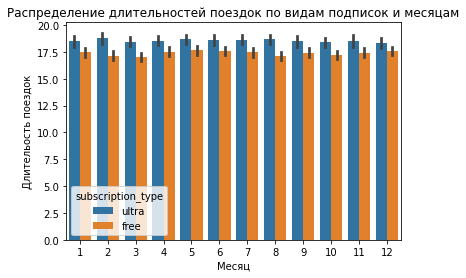

In [47]:
pepe = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = full_data)
pepe.set_title('Распределение длительностей поездок по видам подписок и месяцам')
pepe.set(xlabel='Месяц', ylabel='Длительость поездок');

Так как нулевая гипотеза отвержена, делаем вывод, что пользователи с подпиской ультра больше времени проводят в пути.

**Гипотеза 2:**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

H0: Пользователи с подпиской Ультра проезжают расстояние, РАВНОЕ 3130 мтеров за одну поездку

H1: Пользователи с подпиской Ультра проезжают МЕНЬШЕЕ 3130 мтеров за одну поездку

In [48]:
core_value = 3130
alpha = 0.05

res = st.ttest_1samp(ultra_sub['distance'], core_value, alternative='less')

print('p-value:',checker.pvalue)

if res.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нулевая Гипотеза подтверждается.')

p-value: 1.2804098316645618e-34
Нулевая Гипотеза подтверждается.


Так как нулевая гипотеза подтвердилась, то можно сделать вывод, что пользователи, пользующиеся Ультра подпиской проезжают 3130 метров.

**Гипотеза 3:**

Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

H0: Выручка пользователей с подпиской Ультра РАВНА выручке пользователей с бесплатной подпиской

H1: Выручка пользователей с подпиской Ультра БОЛЬШЕ выручке пользователей с бесплатной подпиской

In [49]:
ultra_income = general_data.loc[general_data.subscription_type == 'ultra', 'ipp'] 
free_income = general_data.loc[general_data.subscription_type == 'free', 'ipp'] 
alpha = 0.05

res = st.ttest_ind(ultra_income, 
                       free_income,
                       alternative = 'greater')
print('p-value:',checker.pvalue)
if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


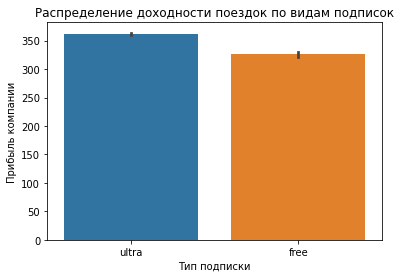

In [55]:
pepe = sns.barplot(x = 'subscription_type',
            y = 'ipp',
            data = general_data)
pepe.set_title('Распределение доходности поездок по видам подписок')
pepe.set(xlabel='Тип подписки', ylabel='Прибыль компании');

Поскольку мы отвергли нулевую гипотезу, то можно сделать вывод о том, что пользователи с подпиской УЛЬТРА приносят больше выручки, чем те пользователи, что пользуются бесплатным тарифом.

**Гипотеза 4:**

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

**Ответ:**

Гипотезу о равенстве средних для зависимых выборок ( st.ttest_rel() ).

Формулировка гипотез будет иметь вид, где μ - это среднее количество обращений в тех.поддержку:

 - H0: μ1 РАВНА μ2
 - H0: μ1 НЕ РАВНА μ2

#### Вывод

По итогам исследовательского анализа данных после предобработки было выявлено:


- Лидирует по количеству пользователей город Пятигорск (14.28% аудитории сервиса). В то же время наименьшее количество пользователей отмечается в Москве (10.95% аудитории сервиса)
- Большинство пользователей сервиса не платят за подписку. Однако таковых всего лишь на 8% больше, нежели платящих клиентов.
- Портрет типичного пользователя сервиса выглядит так: Это молодой человек лет 23-25, который использует сервис по бесплатному тарифу для 15-20-минутных поездок на расстояние от 3 до 4 километров. 

После объединения данных представленных датасетов и дополнительного исследования было выявлено:

- На бесплатном тарифе люди совершают более длинне и продолжительные поездки. В среднем они длятся на 5 минут дольше и преодоленное расстояние больше на 0.7-1 километр.
- Пользователи платного тарифа имеют более чёткую картину поведения. Подавляющая часть поездок совершается на 3 километра и длится 15-18 минут.

Также были исследованы бизнес-гипотезы. По итогам их проверок было составлено 3 тезиса:
1) Пользователи с подпиской ультра больше времени проводят в пути.
2) Пользователи, пользующиеся Ультра подпиской проехжают 3130 метров и более
3) Пользователи с подпиской УЛЬТРА приносят больше выручки, чем те пользователи, что пользуются бесплатным тарифом.

Для проведения более детального анализа в дальнейшем я бы рекомендовал собирать информацию о гендере пользователей, а также об удаленности парковок самокатов от центра города.